# Tutorial : 10x Visium(Breast Cancer)

We utilized spatial transcriptomics data from the 10x Visium platform focusing on breast cancer. The dataset originates from the study *Spatial Transcriptomics Reveal Pitfalls and Opportunities for the Detection of Rare High-Plasticity Breast Cancer Subtypes*.

In [1]:
import os
os.environ['R_HOME']="/share/home/baixiaosheng/software/anaconda/envs/SpaGT/lib/R"
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
import SpaGT
SpaGT.__version__

' 1.0.0 '

In [2]:
file = './cl.h5ad'
adata= ad.read_h5ad(file)

In [3]:
adata, conns = SpaGT.spatial_reconstruction(adata,alpha=1.0)

In [4]:
features_tensor = torch.tensor(adata.obsm['expression_embedding']).float()
relations_tensor = torch.tensor(conns).float()

In [5]:
SpaGT.setup_seed(303)

n_clusters = 5
radius = 50

clf=SpaGT.DEC(features_tensor,relations_tensor,node_width=features_tensor.shape[1], edge_width=relations_tensor.shape[0],num_heads=4,nhid=28,n_clusters=n_clusters)


#Run
a = clf.fit(features_tensor,relations_tensor, init="leiden",num_cluster=n_clusters,res=0.2,n_neighbors=20,pca_num=23)
y_pred, prob,z1=clf.predict() 


adata.obs["pred"] = y_pred
adata.obs["pred"] = adata.obs["pred"].astype('category')

leiden_n_clusters=len(np.unique(y_pred))
print("class:",leiden_n_clusters)


class: 5


In [6]:
adata, refine = SpaGT.refine_label(adata, radius=radius,key='pred')

In [7]:
purity = SpaGT.purity_score(adata.obs['annotation'], adata.obs['pred'])
ARI = adjusted_rand_score(adata.obs['annotation'], adata.obs['pred'])
print("purity: ", purity)
print("ARI: ", ARI)

purity:  0.7171052631578947
ARI:  0.2964973818413119


In [8]:
refine_purity = SpaGT.purity_score(adata.obs['annotation'], adata.obs['label_refined'])
refine_ARI = adjusted_rand_score(adata.obs['annotation'], adata.obs['label_refined'])
print("refine_purity: ", refine_purity)
print("refine_ARI: ", refine_ARI)

refine_purity:  0.6626794258373205
refine_ARI:  0.26464866849348045


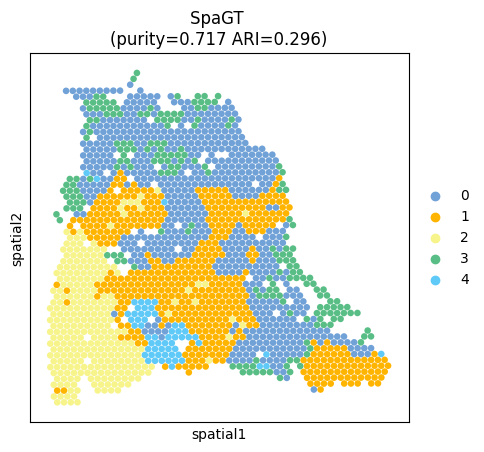

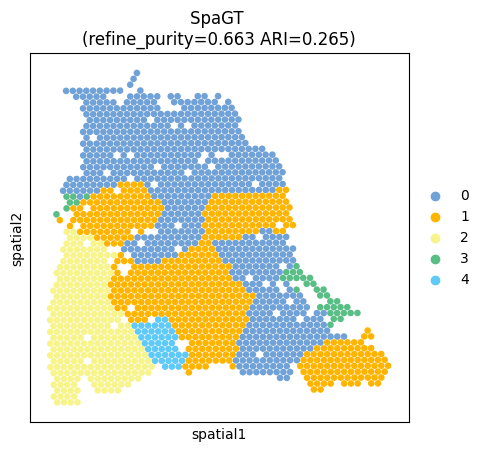

In [9]:
plot_color=["#70a1d7","#ffb400","#f7f48b","#59BE86","#5fc9f8","#F56867","#dedad0"]
sc.pl.spatial(
    adata,
    img_key=None,
    color='pred',
    size=1.5,
    palette=plot_color,
    legend_loc='right margin',
    show=False,
    title=[f'SpaGT \n(purity={purity:.3f} ARI={ARI:.3f})']
)

sc.pl.spatial(
    adata,
    img_key=None,
    color='label_refined',
    size=1.5,
    palette=plot_color,
    legend_loc='right margin',
    show=False,
    title=[f'SpaGT \n(refine_purity={refine_purity:.3f} ARI={refine_ARI:.3f})']
)

plt.show()